# Model Performance
We can assess the models performance by comparing the AI's predictions to the manual corrections. Additionally we can get a sense of how the model is performing by comparing its predictions on the [Medical Segmentation Decathlon](http://medicaldecathlon.com/) (MSD).

## Prerequisites
Install python packages

In [1]:
%%capture
%pip install pandas pydicom pydicom-seg scikit-learn seaborn segmentationmetrics requests

Import required python packages

In [2]:
import warnings

warnings.filterwarnings("ignore")

from pathlib import Path
import requests
import zipfile
import io
import numpy as np
import pandas as pd
import scipy.stats as stats
import pydicom
import pydicom_seg
import SimpleITK as sitk
import matplotlib.pyplot as plt
import segmentationmetrics as sm
from segmentationmetrics.surface_distance import compute_surface_dice_at_tolerance
import seaborn as sns

sns.set_theme(style="whitegrid")
%matplotlib inline

In [3]:
plt_colors = {
    "ne2": "#5eceb0",
    "rad1": "#9e70e1",
    "tp": "k",
    "fp": "b",
    "fn": "r",
}

revewer_cmap = sns.color_palette([plt_colors["ne2"], plt_colors["rad1"]])
vol_cmap = sns.color_palette([plt_colors["fp"], plt_colors["fn"]])

To compare model performance against the manual corrections, we need to download the dicom-seg files of the ai predictions and the manual corrections from zenodo.

In [4]:
qa_dir = Path("qa-results")

In [5]:
def download_inference(
    extract_dir="qa-results",
    url="https://zenodo.org/record/10009368/files/liver-ct.zip",
):
    # download the zip file and extract it
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_dir)


if not (qa_dir / "ai-segmentations-dcm").exists():
    download_inference()

## Data Description
The dataset was reviewed by two reviewers, a radiologist and a 'non-expert'. The non-expert was a medical student with some familiarity with radiology images. For this project, the non-expert scored every ai prediction while the radiologist only scored the validation set.

Alone with the segmentation files, we also have a qa-resulst.csv file that gives more information on the quality assessment feedback from the manual reviewers.

| column                      | description                                                                                      |
| --------------------------- | ------------------------------------------------------------------------------------------------ |
| Reviewer                    | Either `rad1` or `ne1` for Radiologist 1 and Non-expert 1 respectively                           |
| Validataion                 | if this scan was in the validation set                                                           |
| Collection                  | IDC collection name                                                                              |
| PatientID                   | PatientID from dicom                                                                             |
| StudyDate                   | StudyDate from dicom                                                                             |
| StudyDate_suffix            | incrementing value to differentiate different scans from the same StudyDate                      |
| StudyInstanceUID            | StudyInstanceUID from dicom                                                                      |
| SeriesInstanceUID           | SeriesInstanceUID from dicom                                                                     |
| AISegmentation              | filename of ai segmentation                                                                      |
| LikertScore                 | Reviewers opinion of how accurate the AI prediction was, see table below fr                      |
| CommentsAboutAISegmentation | comments from the reviewer about the ai segmentation, usually how the AI underperformed          |
| CommentsAboutScan           | comments from the reviewer about the scan, could be about unusual anatomy or scan artifacts.     |
| CorrectedSegmentation       | file name of the manually corrected segmentation, this file is in `qa-segmentations-dcm`` folder |

The Likert scale used for scoring was:

| Score | Meaning |
| --- | --- |
| 5 | Strongly Agree - Use-as-is (i.e., clinically acceptable, and could be used for treatment without change) |
| 4 | Agree - Minor edits that are not necessary. Stylistic differences, but not clinically important. The current segmentation is acceptable |
| 3 | Neither agree nor disagree - Minor edits that are necessary. Minor edits are those that the review judges can be made in less time than starting from scratch or are expected to have minimal effect on treatment outcome |
| 2 | Disagree - Major edits. This category indicates that the necessary edit is required to ensure correctness, and sufficiently significant that user would prefer to start from the scratch |
| 1 | Strongly disagree - Unusable. This category indicates that the quality of the automatic annotations is so bad that they are unusable.|


In [6]:
df = pd.read_csv(
    qa_dir / "qa-results.csv",
    dtype={
        "PatientID": str,
        "StudyDate": str,
        "StudyDate_suffix": str,
        "LikertScore": int,
    },
)
df.replace(
    {"rad1": "Radiologist", "ne1": "Non-expert"},
    inplace=True,
)

# get validation subset
val_df = df[df["Validation"]]
validation_size = len(val_df["SeriesInstanceUID"].unique())
total_size = len(df["SeriesInstanceUID"].unique())
print(
    f"{validation_size/total_size*100:.2f}% of scans were validated ({validation_size}/{total_size})"
)

# get validation done by different reviewers
rad_df = val_df.loc[val_df["Reviewer"] == "Radiologist"]
ne_df = val_df.loc[
    (val_df["Reviewer"] == "Non-expert")
    & (val_df["AISegmentation"]).isin(rad_df["AISegmentation"])
]

rad_df = rad_df.sort_values(by=["AISegmentation"])
ne_df = ne_df.sort_values(by=["AISegmentation"])

assert len(rad_df) == len(ne_df)
assert len(rad_df) == len(rad_df["AISegmentation"].unique())

print(f"{len(rad_df)} scans were reviewed by radiologist and non-expert")

10.11% of scans were validated (9/89)
9 scans were reviewed by radiologist and non-expert


We caluclate the Kendall-𝜏 score between the two reviewers. Kendall-𝜏 is a measure of correlation between raters of ordinal data. This tells us how much we can trust the scores given by the non-expert reviewer for the portion of the dataset the Radiologist did not review.

For this dataset, there is significant correlation between the two reviewers. 


In [7]:
tau, p_value = stats.kendalltau(rad_df.LikertScore.values, ne_df.LikertScore.values)
print(f"Kendall's 𝜏: {tau:.2f}, p-value: {p_value:.2f}")

# Calculate percentage agreement

total_cases = len(rad_df.LikertScore)
matching_cases = np.sum(rad_df.LikertScore.values == ne_df.LikertScore.values)
percentage_agreement = (matching_cases / total_cases) * 100

print(f"Percentage Agreement: {percentage_agreement:.2f}%")

Kendall's 𝜏: 0.70, p-value: 0.03
Percentage Agreement: 66.67%


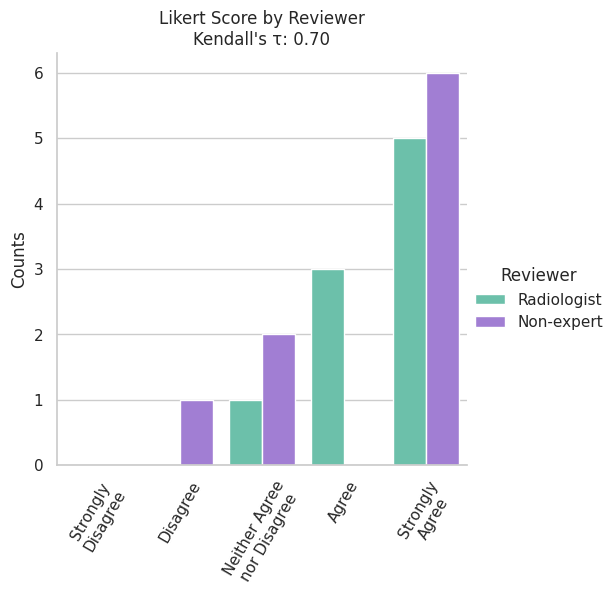

In [8]:
g = sns.catplot(
    data=val_df,
    kind="count",
    x="LikertScore",
    order=[1, 2, 3, 4, 5],
    hue="Reviewer",
    hue_order=["Radiologist", "Non-expert"],
    palette=revewer_cmap,
)
g.set_axis_labels("", "Counts")
g.set(title=f"Likert Score by Reviewer\nKendall's \u03c4: {tau:.2f}")
g.set_xticklabels(
    labels=[
        "Strongly\nDisagree",
        "Disagree",
        "Neither Agree\nnor Disagree",
        "Agree",
        "Strongly\nAgree",
    ],
    rotation=60,
)

Text(0.5, 1.0, 'Likert Score Distribution for Radiologist')

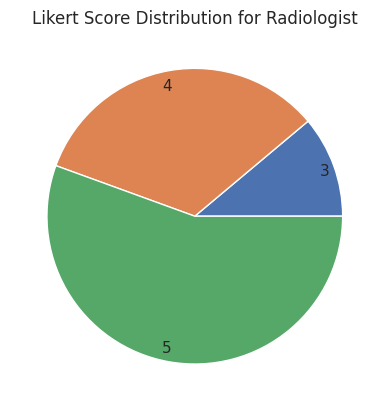

In [9]:
pie_df = (
    rad_df["LikertScore"].value_counts().reset_index().sort_values(by="LikertScore")
)
plt.pie(
    pie_df["count"].values,
    labels=pie_df["LikertScore"].values,
    labeldistance=0.9,
)
plt.title("Likert Score Distribution for Radiologist")

The reviewers also corrected the AI predictions for the validation set when their Likert rating was not 5. We can assess the reviewers agreement with the AI from segmentation metrics of Dice Similarity Coefficient (DSC), 95% Hausdorff distance, and Normalized Mean Surface Distance (NSD).

DSC measures volume similarity between two segmentations.

95% Hausdorff distance measures the agreement between surfaces. This is the distance were 95% of points on the surface are within the specified distance of the other surface.

NSD measures the average distance between the surfaces. It includes an acceptable tolerance that is dependant on the task. For liver segmentation, the Medical Segmentation Decathlon set this tolerance to 7mm.

In [10]:
def load_dcm_seg(seg_path: Path, label=1):
    dcm = pydicom.dcmread(str(seg_path))
    reader = pydicom_seg.SegmentReader()
    result = reader.read(dcm)
    image = result.segment_image(label)
    image = sitk.Cast(image, sitk.sitkUInt8)
    return image


def load_nii_seg(seg_path: Path, label=1):
    img = sitk.ReadImage(str(seg_path))
    img = sitk.Cast(img == label, sitk.sitkUInt8)
    return img


def load_seg(seg_path: Path, label=1):
    if seg_path.suffix == ".dcm":
        return load_dcm_seg(seg_path, label)
    else:
        return load_nii_seg(seg_path, label)


def resize_label(img: sitk.Image, ref_img: sitk.Image, interp=sitk.sitkNearestNeighbor):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ref_img)
    resampler.SetInterpolator(interp)
    resampler.SetDefaultPixelValue(0)
    resampled_img = resampler.Execute(img)
    return resampled_img


def calc_metrics_for_label(ai_seg_file, qa_seg_file, label_value=1, label_suffix=""):
    ai_img = load_seg(ai_seg_file, label_value)
    qa_img = load_seg(qa_seg_file, label_value)
    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    ai_arr = sitk.GetArrayFromImage(ai_img)
    qa_arr = sitk.GetArrayFromImage(qa_img)
    spacing = ai_img.GetSpacing()[::-1]  # numpy is reversed dimensions from sitk

    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    m = sm.SegmentationMetrics(ai_arr, qa_arr, spacing)

    metrics = {
        "dice": m.dice,
        "hausdorff_distance_95": m.hausdorff_distance,
        "mean_surface_distance": m.mean_surface_distance,
        "mean_surface_distance_tol_7": compute_surface_dice_at_tolerance(
            m._surface_dist, 7
        ),  # from medical segmentation decathlon
    }
    if label_suffix:
        metrics = {f"{k}_{label_suffix}": v for k, v in metrics.items()}
    return metrics


def add_metrics_to_df(df):
    for i, row in df.iterrows():
        ai_seg_file = qa_dir / "ai-segmentations-dcm" / row["AISegmentation"]
        if row["LikertScore"] < 5:
            qa_seg_file = qa_dir / "qa-segmentations-dcm" / row["CorrectedSegmentation"]
        else:
            qa_seg_file = ai_seg_file

        assert ai_seg_file.exists()
        assert qa_seg_file.exists()

        metrics = calc_metrics_for_label(ai_seg_file, qa_seg_file)
        metrics["label"] = "liver"
        for k, v in metrics.items():
            df.loc[i, k] = v

In [11]:
add_metrics_to_df(rad_df)
add_metrics_to_df(ne_df)

xdf = pd.concat([rad_df, ne_df])

In [16]:
xdf[
    [
        "label",
        "Reviewer",
        "dice",
        "hausdorff_distance_95",
        "mean_surface_distance",
        "mean_surface_distance_tol_7",
    ]
].replace([np.inf, -np.inf], np.nan).dropna().groupby(["label", "Reviewer"]).agg(
    {
        "dice": ["mean", "std"],
        "hausdorff_distance_95": ["mean", "std"],
        "mean_surface_distance": ["mean", "std"],
        "mean_surface_distance_tol_7": ["mean", "std"],
    }
).round(
    2
)

dice       hausdorff_distance_95         \
                   mean   std                  mean    std   
label Reviewer                                               
liver Non-expert   0.97  0.08                  5.57  12.71   
      Radiologist  0.97  0.07                  5.66  10.75   

                  mean_surface_distance       mean_surface_distance_tol_7  \
                                   mean   std                        mean   
label Reviewer                                                              
liver Non-expert                   0.87  2.08                        0.95   
      Radiologist                  0.81  1.67                        0.96   

                         
                    std  
label Reviewer           
liver Non-expert   0.11  
      Radiologist  0.09

The DSC between the reviewers is similar, with only one scan ranked lower than 0.95

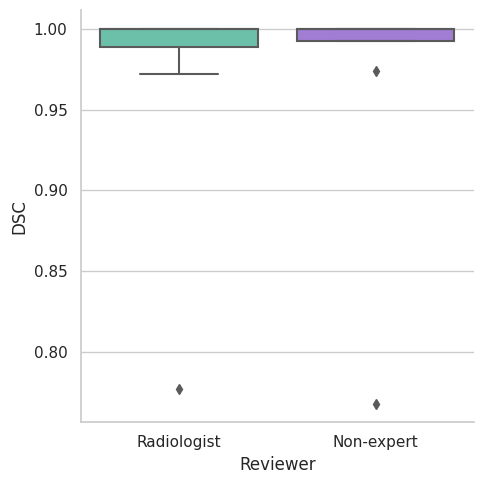

In [17]:
g = sns.catplot(data=xdf, x="Reviewer", y="dice", kind="box", palette=revewer_cmap)
g.set_axis_labels("Reviewer", "DSC")

The NSD is also high for both reviewers, but the non-expert reviewer has a higher NSD than the radiologist.

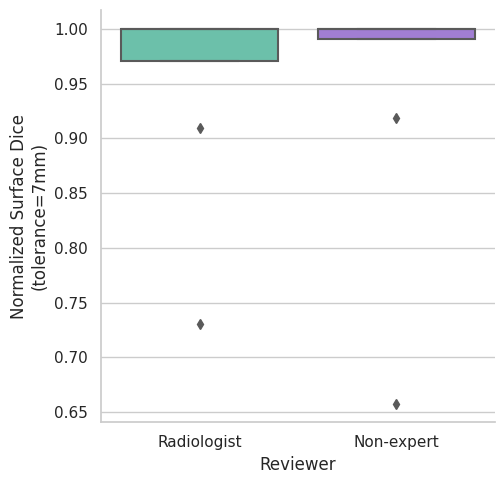

In [18]:
g = sns.catplot(
    data=xdf,
    x="Reviewer",
    y="mean_surface_distance_tol_7",
    kind="box",
    palette=revewer_cmap,
)
g.set_axis_labels("Reviewer", "Normalized Surface Dice\n(tolerance=7mm)")

The 95% Hausdorff distance is also similar between the reviewers. Again the non-expert agrees with the AI more than the radiologist.

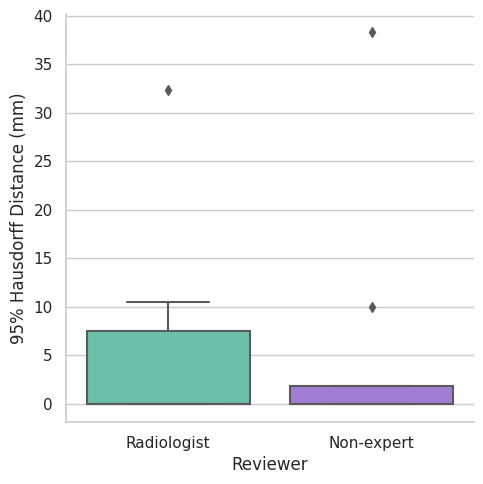

In [19]:
g = sns.catplot(
    data=xdf, x="Reviewer", y="hausdorff_distance_95", kind="box", palette=revewer_cmap
)
g.set_axis_labels("Reviewer", "95% Hausdorff Distance (mm)")

We can compare the segmentation metrics to the reviewers likert scores. Generally they correlate, but there is one case scored at 4 which performs very badly across all segmentation metrics, worse then segmenations rated as 3.

        Radiologist: Kendall-τ: 0.86, p-value: 0.01
        Non-expert: Kendall-τ: 0.98, p-value: 0.00
        


[Text(0.5, 19.049999999999997, 'Likert Score'), Text(27.375, 0.5, 'DSC')]

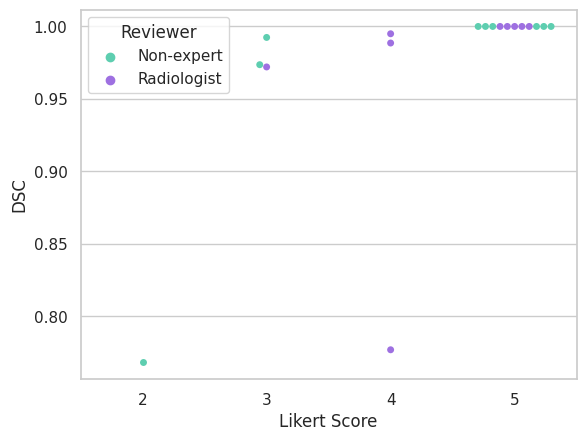

In [20]:
x = rad_df[["LikertScore", "dice"]].dropna()
rad_tau, rad_p_value = stats.kendalltau(x.LikertScore.values, x.dice.values)
x = ne_df[["LikertScore", "dice"]].dropna()
ne_tau, ne_p_value = stats.kendalltau(x.LikertScore.values, x.dice.values)

print(
    f"""\
        Radiologist: Kendall-\u03C4: {rad_tau:.2f}, p-value: {rad_p_value:.2f}
        Non-expert: Kendall-\u03C4: {ne_tau:.2f}, p-value: {ne_p_value:.2f}
        """
)

# plot likert score vs dice
g = sns.swarmplot(
    data=xdf, x="LikertScore", y="dice", hue="Reviewer", palette=revewer_cmap
)
g.set(xlabel="Likert Score", ylabel="DSC")

        Radiologist: Kendall-τ: 0.86, p-value: 0.01
        Non-expert: Kendall-τ: 0.98, p-value: 0.00
        


[Text(0.5, 19.049999999999997, 'Likert Score'),
 Text(27.375, 0.5, 'Normalized Surface Dice\n(tolerance=7mm)')]

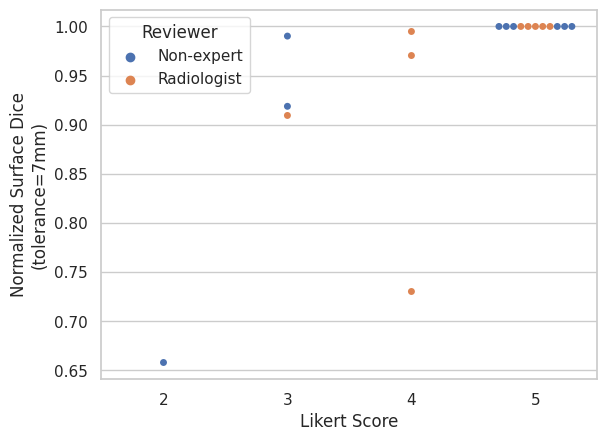

In [21]:
x = rad_df[["LikertScore", "mean_surface_distance_tol_7"]].dropna()
rad_tau, rad_p_value = stats.kendalltau(
    x.LikertScore.values, x.mean_surface_distance_tol_7.values
)
x = ne_df[["LikertScore", "mean_surface_distance_tol_7"]].dropna()
ne_tau, ne_p_value = stats.kendalltau(
    x.LikertScore.values, x.mean_surface_distance_tol_7.values
)

print(
    f"""\
        Radiologist: Kendall-\u03C4: {rad_tau:.2f}, p-value: {rad_p_value:.2f}
        Non-expert: Kendall-\u03C4: {ne_tau:.2f}, p-value: {ne_p_value:.2f}
        """
)

# plot likert score vs nsd
g = sns.swarmplot(
    data=xdf, x="LikertScore", y="mean_surface_distance_tol_7", hue="Reviewer"
)
g.set(xlabel="Likert Score", ylabel="Normalized Surface Dice\n(tolerance=7mm)")

        Radiologist: Kendall-τ: -0.86, p-value: 0.01
        Non-expert: Kendall-τ: -0.98, p-value: 0.00
        


[Text(0.5, 19.049999999999997, 'Likert Score'),
 Text(41.875, 0.5, '95% Hausdorff Distance (mm)')]

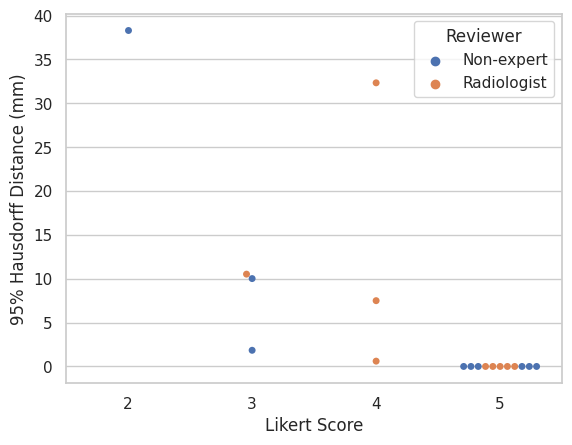

In [22]:
x = rad_df[["LikertScore", "hausdorff_distance_95"]].dropna()
rad_tau, rad_p_value = stats.kendalltau(
    x.LikertScore.values, x.hausdorff_distance_95.values
)
x = ne_df[["LikertScore", "hausdorff_distance_95"]].dropna()
ne_tau, ne_p_value = stats.kendalltau(
    x.LikertScore.values, x.hausdorff_distance_95.values
)

print(
    f"""\
        Radiologist: Kendall-\u03C4: {rad_tau:.2f}, p-value: {rad_p_value:.2f}
        Non-expert: Kendall-\u03C4: {ne_tau:.2f}, p-value: {ne_p_value:.2f}
        """
)

# plot likert score vs dice
g = sns.swarmplot(data=xdf, x="LikertScore", y="hausdorff_distance_95", hue="Reviewer")
g.set(xlabel="Likert Score", ylabel="95% Hausdorff Distance (mm)")

## Performance on Medical Segmentation Decathlon dataset
First we need to generate the predictions for the Liver task of MSD. Download the Liver task data and generate the model predictions using the docker image as described in the [README](README.md). Adjust the predictions and ground truth label paths as needed.

In [23]:
msd_preds = Path("MSD/Task03_Liver/predTr")
msd_gt = Path("MSD/Task03_Liver/labelsTr")

msd_df = pd.DataFrame.from_dict(
    {
        "ai": sorted(list(msd_preds.glob("*.nii.gz"))),
        "gt": sorted(list(msd_gt.glob("*.nii.gz"))),
    }
)
for i, row in msd_df.iterrows():
    ai_seg_file = row["ai"]
    qa_seg_file = row["gt"]

    assert ai_seg_file.exists()
    assert qa_seg_file.exists()
    assert ai_seg_file.name == qa_seg_file.name

    metrics = calc_metrics_for_label(ai_seg_file, qa_seg_file)
    metrics["label"] = "liver"
    for k, v in metrics.items():
        msd_df.loc[i, k] = v

In [24]:
msd_df[
    [
        "dice",
        "hausdorff_distance_95",
        "mean_surface_distance",
        "mean_surface_distance_tol_7",
    ]
].mean().round(2)

dice                            0.94
hausdorff_distance_95          18.01
mean_surface_distance           2.20
mean_surface_distance_tol_7     0.95
dtype: float64

nnUNet was the winning algorithm in the Medical Segmentation Decathlon. MSD scored entries for Dice Similarity Coefficient and Noramlized Surface Distance (tolerance=7mm) for the liver task. We trained nnUnet on a different CT dataset.

| Algorithm     | Mean DSC | Mean NSD |
| ------------- | -------- | -------- |
| nnUnet MSD    | 0.95     | 0.98     |
| nnUnet (ours) | 0.94     | 0.95     |
